In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Reshape, Flatten, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import ReLU, LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.utils import multi_gpu_model

import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

import shutil, os, sys, io, random, math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
from tqdm import tqdm

os.chdir('/home/k_yonhon/py/Keras-GAN/pggan/')
sys.path.append(os.pardir)

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

gpu_count = 2

In [2]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, 
                          averaged_samples,
                          gradient_penalty_weight):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr, 
                              axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = gradient_penalty_weight * K.square(gradient_l2_norm - 1)
    return K.mean(gradient_penalty)

In [3]:
class WGANGP():
    def __init__(self):
        # ---------------------
        #  for log on TensorBoard
        # ---------------------
        target_dir = "./my_log_dir"
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Parameter
        # ---------------------      
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.input_rows = 4
        self.input_cols = 4
        self.latent_dim = 128  # Noiseの次元
        
        self.n_critic = 5
        self.λ = 10        
        optimizer = Adam(lr=0.0001, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)

        # ---------------------
        #  Build model
        # ---------------------
        self.critic = self.build_critic()
        self.generator = self.build_generator()
        
        #  Load pretrained weights        
        pre_gen = load_model('./saved_model/wgangp32_gen_model.h5')
        for i, layer in enumerate(self.generator.layers[1].layers):
            if i in [i for i in range(1, int(math.log(self.img_rows / self.input_rows, 2)) * 2, 2)]:
                layer.set_weights(pre_gen.layers[1].layers[i].get_weights())
                layer.trainable = False
                
        pre_critic = load_model('./saved_model/wgangp32_critic_model.h5')
        for i, layer in enumerate(self.critic.layers[1].layers):
            j = i - len(self.critic.layers[1].layers)
            if j in [-i for i in range(int(math.log(self.img_rows / self.input_rows, 2)) * 2, 0, -2)]:
                layer.set_weights(pre_critic.layers[1].layers[j].get_weights())
                layer.trainable = False

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------    
        generated_samples = Input(shape=self.img_shape) 
        critic_output_from_generated_samples = self.critic(generated_samples)
        
        real_samples = Input(shape=self.img_shape)        
        critic_output_from_real_samples = self.critic(real_samples)

        averaged_samples = Input(shape=self.img_shape)
        critic_output_from_averaged_samples = self.critic(averaged_samples)

        partial_gp_loss = partial(gradient_penalty_loss,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.λ)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        self.critic_model = Model(inputs=[generated_samples, 
                                          real_samples,
                                          averaged_samples],
                                  outputs=[critic_output_from_generated_samples, 
                                           critic_output_from_real_samples,
                                           critic_output_from_averaged_samples])
        if gpu_count > 1:
            self.critic_model = multi_gpu_model(self.critic_model, gpus=gpu_count)
        self.critic_model.compile(optimizer=optimizer, 
                                  loss=[wasserstein_loss, 
                                        wasserstein_loss, 
                                        partial_gp_loss])
        
        print('Critic Summary:')
        self.critic.summary()       
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------
        # For the generator we freeze the critic's layers
        self.critic.trainable = False
                    
        generator_input = Input(shape=(self.latent_dim,))
        generator_layers = self.generator(generator_input)
        critic_layers_for_generator = self.critic(generator_layers)
        
        self.generator_model = Model(inputs=[generator_input], 
                                     outputs=[critic_layers_for_generator])
        if gpu_count > 1:
            self.generator_model = multi_gpu_model(self.generator_model, gpus=gpu_count)
        self.generator_model.compile(optimizer=optimizer,
                                     loss=wasserstein_loss)        

        print('Genarator Summary:')
        self.generator.summary()   

    def build_generator(self):
        model = Sequential()
        model.add(Reshape((self.input_rows, self.input_cols, int(self.latent_dim / (self.input_rows * self.input_cols))), 
                          input_shape=(self.latent_dim,)
                         ))

        model.add(Conv2DTranspose(512, (3, 3), strides=1, padding='same',
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))      

        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            model.add(Conv2DTranspose(512, (3, 3), strides=2, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(256, (3, 3), strides=1, padding='same', 
                                  kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                  ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(128, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(32, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(16, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))                
        model.add(Activation("tanh"))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_critic(self):
        model = Sequential()
        model.add(Conv2D(16, (1, 1), strides=1, input_shape=self.img_shape, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(32, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(64, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(128, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(256, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(512, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            model.add(Conv2D(512, (3, 3), strides=2, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(1, (4, 4), strides=1, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(Flatten())

        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size, sample_interval=50, resume=0):
        # Load suspended training weights
        if resume != 0:
            self.critic = load_model('./saved_model/wgangp64_critic_model_'+str(resume)+'epoch.h5')
            self.generator = load_model('./saved_model/wgangp64_gen_model_'+str(resume)+'epoch.h5')
        
        # Load the dataset
        X_train = np.load('../datasets/lfw64.npz')['arr_0']
        X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1), dtype=np.float32)
        fake = np.ones((batch_size, 1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32)

        # ---------------------
        #  Training
        # ---------------------
        for epoch in tqdm(range(resume, resume + epochs + 1)):
            for _ in range(self.n_critic):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise, batch_size=batch_size)
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_imgs = X_train[idx]
                               
                ε = np.random.uniform(size=(batch_size, 1,1,1))
                ave_imgs = ε * real_imgs + (1-ε) * gen_imgs
                
                # Train Critic
                d_loss = self.critic_model.train_on_batch([gen_imgs, real_imgs, ave_imgs], 
                                                          [fake, valid, dummy])

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.generator_model.train_on_batch(noise, valid)
            
            # Backup Model
            if epoch != 0 and epoch % 1000 == 0:
                self.critic.save('./saved_model/wgangp64_critic_model_'+str(epoch+resume)+'epoch.h5')
                self.generator.save('./saved_model/wgangp64_gen_model_'+str(epoch+resume)+'epoch.h5')
            
            # Log Loss & Histgram
            logs = {
                "loss/Critic": d_loss[0],
                "loss/Generator": g_loss,
                "loss_Critic/D_gen": d_loss[1],
                "loss_Critic/D_real": -d_loss[2],
                "loss_Critic/gradient_penalty": d_loss[3],
                "loss_Critic/total_loss": d_loss[1] + d_loss[2] + d_loss[3],                
            }

            histograms = {}
            for layer in self.critic.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch+resume)
            
            # Log generated image samples
            if epoch+resume == 1000 or epoch+resume == 2000 or (epoch+resume) % sample_interval == 0:
                fig, name = self.sample_images(epoch+resume, dataset=X_train)
                images = {name: fig}
                self.logger.log(images=images, epoch=epoch+resume)
                print("%d [C loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

    def sample_images(self, epoch, dataset):
        r, c = 3, 3
        if epoch == 0:
            idx = np.random.randint(0, dataset.shape[0], r * c)
            imgs = dataset[idx]
        else:
            noise = np.random.normal(0, 1, (r * c, self.latent_dim))
            imgs = self.generator.predict(noise, batch_size=r * c)

        # Rescale images 0 - 255
        imgs = ((0.5 * imgs + 0.5) * 255).astype(np.uint8)
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                if self.channels == 1:
                    axs[i, j].imshow(imgs[cnt, :, :, 0], cmap="gray")
                else:
                    axs[i, j].imshow(imgs[cnt, :, :, :self.channels], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        if epoch == 0:
            name = "original.png"
        else:
            name = str(epoch) + ".png"
        return fig, name

In [4]:
wgan = WGANGP()

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Critic Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 11019809  
Total params: 11,019,809
Trainable params: 3,932,192
Non-trainable params: 7,087,617
_________________________________________________________________
Genarator Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 64, 64, 3)         11048867  
Total params: 11,048,867
Trainable params: 3,932,067
Non-trainable params: 7,116,800
_________________________________________________________________


  0%|          | 0/10001 [00:00<?, ?it/s]/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/10001 [00:42<117:20:55, 42.25s/it]

0 [C loss: -48.661079] [G loss: 32.542683]


  0%|          | 18/10001 [03:23<25:49:41,  9.31s/it]

KeyboardInterrupt: 

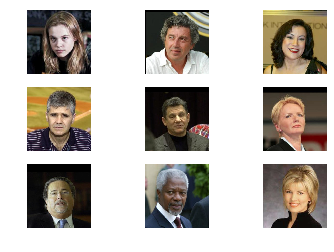

In [ ]:
wgan.train(epochs=10000, batch_size=64, sample_interval=1000, resume=0)

In [ ]:
wgan.generator.save('./saved_model/wgangp64_gen_model.h5')
wgan.critic.save('./saved_model/wgangp64_critic_model.h5')